# Configurações Iniciais

Primeiramente, vamos importar algumas bibliotecas que utilizaremos inicialmente.

In [1]:
import numpy as np
import os
import pandas as pd

Vamos fixar uma semente aleatória para o restante do modelo.

In [2]:
seed = 4
np.random.seed(seed)

Importando módulos básicos para plotar figuras e gráficos.

In [3]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rc('axes', labelsize=7)
mpl.rc('xtick', labelsize=9)
mpl.rc('ytick', labelsize=9)

# Enquadrando o problema

Considere o seguinte cenário: A empresa Carrara Empréstimos notou perdas significativas devido à inadimplência de empréstimos de veículos. Isso levou a uma maior rigidez na  subscrição de empréstimos de veículos e ao aumento das taxas de rejeição. Afim de sanar a necessidade de um melhor modelo de pontuação de risco de crédito, a Carrara Empréstimos nos contratou para implementar um modelo que preve com precisão a probabilidade de um cliente inadimplir um empréstimo de veículo na primeira prestação mensal na data de vencimento.

Para isto a empresa nos fornceu um dataset que iremos detalhar mais a frente.

# Obtendo os dados

Como o dataset é muito grande, vamos importa-lo do google drive.

In [5]:
!pip install gdown

!gdown --id '10RooMx1FwE3Ujp8VKJhNJlotT2XTLVs6' #train
!gdown --id '1jgJT6T8UA27mfjV3OPnBdh_Re7LNsbvK'#test

df = pd.read_csv('train.csv')


Vamos transformar agora em um DataFrame

In [6]:
columns = df.columns.tolist()
loans = pd.DataFrame(df, columns=columns)

Façamos uma cópia do loans para uso futuro (será explicado na extratificação de dados).

In [7]:
loan_ord = loans.copy()

# Conhecendo os dados

Vamos printar as 5 primeiras linhas de dados.

In [8]:
loans.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,...,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,...,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,...,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1


Vamos verificar os tipos de dados e analisar se temos alguma coluna com valores NaN.

In [9]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233154 entries, 0 to 233153
Data columns (total 41 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   UniqueID                             233154 non-null  int64  
 1   disbursed_amount                     233154 non-null  int64  
 2   asset_cost                           233154 non-null  int64  
 3   ltv                                  233154 non-null  float64
 4   branch_id                            233154 non-null  int64  
 5   supplier_id                          233154 non-null  int64  
 6   manufacturer_id                      233154 non-null  int64  
 7   Current_pincode_ID                   233154 non-null  int64  
 8   Date.of.Birth                        233154 non-null  object 
 9   Employment.Type                      225493 non-null  object 
 10  DisbursalDate                        233154 non-null  object 
 11  State_ID     

Observe que a coluna Employment.Type possui menos células preenchidas do que o total de linhas. Portanto, será necessário realizar a imputação dos dados.



#### **Informações de Identificação do Cliente**
* **UniqueID:** Identificador único do cliente para diferenciar registros individuais.

#### **Variável-Alvo**
* **loan_default:** Indicador se o cliente não pagou a primeira parcela do empréstimo na data de vencimento (1 = inadimplente, 0 = adimplente).

#### **Detalhes de Empréstimo**
* **disbursed_amount:** Valor do empréstimo desembolsado ao cliente.
* **asset_cost:** Custo do ativo financiado (ex.: veículo).
* **ltv (Loan-to-Value):** Proporção entre o valor do empréstimo e o custo do ativo financiado.

#### **Informações Geográficas e Operacionais**
* **branch_id:** Identificação da agência que desembolsou o empréstimo.
* **supplier_id:** Identificação da concessionária onde o ativo foi financiado.
* **manufacturer_id:** Identificação do fabricante do ativo (ex.: Hero, Honda, TVS).
* **Current_pincode:** Código postal do cliente no momento do empréstimo.
* **State_ID:** Estado onde o empréstimo foi desembolsado.
* **Employee_code_ID:** Identificação do funcionário que processou o empréstimo.

#### **Informações Demográficas**
* **Date.of.Birth:** Data de nascimento do cliente.
* **Employment.Type:** Tipo de emprego do cliente (assalariado ou autônomo).

#### **Documentos Compartilhados**
Indicadores binários (1 = Sim, 0 = Não) para documentos compartilhados pelo cliente:
* **MobileNo_Avl_Flag:** Número de celular.
* **Aadhar_flag:** Aadhaar (identificação nacional única).
* **PAN_flag:** PAN (identificação tributária da Índia).
* **VoterID_flag:** Documento de eleitor.
* **Driving_flag:** Carteira de motorista (DL).
* **Passport_flag:** Passaporte.

#### **Histórico de Crédito e Comportamento**
* **PERFORM_CNS.SCORE:** Pontuação de crédito do cliente usada para avaliação de risco.
* **PERFORM_CNS.SCORE.DESCRIPTION:** Descrição associada à pontuação de crédito.

##### **Empréstimos Primários (PRI):**
* **PRI.NO.OF.ACCTS:** Número total de contas de empréstimos registrados.
* **PRI.ACTIVE.ACCTS:** Contagem de contas de empréstimos ativas.
* **PRI.OVERDUE.ACCTS:** Contagem de contas de empréstimos em atraso.
* **PRI.CURRENT.BALANCE:** Saldo principal total em aberto nos empréstimos ativos.
* **PRI.SANCTIONED.AMOUNT:** Valor total sancionado para empréstimos.
* **PRI.DISBURSED.AMOUNT:** Valor total desembolsado para empréstimos.

##### **Empréstimos Secundários (SEC):**
* **SEC.NO.OF.ACCTS:** Número total de contas de empréstimos secundários.
* **SEC.ACTIVE.ACCTS:** Contagem de contas secundárias ativas.
* **SEC.OVERDUE.ACCTS:** Contagem de contas secundárias em atraso.
* **SEC.CURRENT.BALANCE:** Saldo principal total em aberto de empréstimos secundários.
* **SEC.SANCTIONED.AMOUNT:** Valor total sancionado para empréstimos secundários.
* **SEC.DISBURSED.AMOUNT:** Valor total desembolsado para empréstimos secundários.

#### **Comportamento Financeiro**
* **PRIMARY.INSTAL.AMT:** Valor das parcelas (EMI) de empréstimos primários.
* **SEC.INSTAL.AMT:** Valor das parcelas (EMI) de empréstimos secundários.
* **NEW.ACCTS.IN.LAST.SIX.MONTHS:** Quantidade de novos empréstimos tomados pelo cliente nos últimos 6 meses.
* **DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS:** Contagem de contas inadimplentes nos últimos 6 meses.
* **AVERAGE.ACCT.AGE:** Prazo médio dos empréstimos em meses ou anos.
* **CREDIT.HISTORY.LENGTH:** Duração do histórico de crédito desde o primeiro empréstimo.
* **NO.OF_INQUIRIES:** Número de consultas realizadas pelo cliente para obter empréstimos (indicador de busca por crédito).


# Separando o conjuto de dados

O nosso dataset original (fornecido pela empresa) já está divido entre treino e teste. Importamos, por enquanto, apenas o conjunto de treino.

Visando evitar ao máximo o enviezamento, vamos trabalhar exclusivamente com nosso conjunto de treino. Inclusive o mesmo entre um treino e teste, onde nesse segundo calcularemos uma estimativa do erro de generalização, antes mesmo de importar o real conjunto de teste. Essa escolha nos permite fazer mudanças no nosso modelo antes calcularmos o real erro de generalização.

Agora, vamos separar nosso conjunto de dados entre treino e teste de duas formas:

* Estratificando uma feature;
* Separando de maneira aleatória.

Após essas duas abordagens, vamos compará-las para ver qual escolher.

Iremos fazer nossa estratificação com base na PERFORM_CNS.SCORE.DESCRIPTION para garantir que nosso conjunto de teste tenha representatividade de todos os perfis de risco. Além disso, acreditamos que essa variável tenha grande correlação com nossa variável alvo.

In [10]:
loans["PERFORM_CNS.SCORE.DESCRIPTION"].value_counts()

PERFORM_CNS.SCORE.DESCRIPTION
No Bureau History Available                                116950
C-Very Low Risk                                             16045
A-Very Low Risk                                             14124
D-Very Low Risk                                             11358
B-Very Low Risk                                              9201
M-Very High Risk                                             8776
F-Low Risk                                                   8485
K-High Risk                                                  8277
H-Medium Risk                                                6855
E-Low Risk                                                   5821
I-Medium Risk                                                5557
G-Low Risk                                                   3988
Not Scored: Sufficient History Not Available                 3765
J-High Risk                                                  3748
Not Scored: Not Enough Info available on the c

Vamos estraticar usando as classes ja estabelecidas do PERFORM_CNS.SCORE.DESCRIPTION

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)

for train_index, test_index in split.split(loans, loans["PERFORM_CNS.SCORE.DESCRIPTION"]):
    strat_train_set = loans.loc[train_index]
    strat_test_set = loans.loc[test_index]

Vamos agora verificar como está distribuída a feature "PERFORM_CNS.SCORE.DESCRIPTION" no conjunto treino.

In [12]:
strat_test_set["PERFORM_CNS.SCORE.DESCRIPTION"].value_counts() / len(strat_test_set)

PERFORM_CNS.SCORE.DESCRIPTION
No Bureau History Available                                0.501598
C-Very Low Risk                                            0.068817
A-Very Low Risk                                            0.060582
D-Very Low Risk                                            0.048723
B-Very Low Risk                                            0.039459
M-Very High Risk                                           0.037636
F-Low Risk                                                 0.036392
K-High Risk                                                0.035491
H-Medium Risk                                              0.029401
E-Low Risk                                                 0.024962
I-Medium Risk                                              0.023825
G-Low Risk                                                 0.017113
Not Scored: Sufficient History Not Available               0.016148
J-High Risk                                                0.016084
Not Scored: Not En

In [13]:
loans["PERFORM_CNS.SCORE.DESCRIPTION"].value_counts() / len(loans)

PERFORM_CNS.SCORE.DESCRIPTION
No Bureau History Available                                0.501600
C-Very Low Risk                                            0.068817
A-Very Low Risk                                            0.060578
D-Very Low Risk                                            0.048715
B-Very Low Risk                                            0.039463
M-Very High Risk                                           0.037640
F-Low Risk                                                 0.036392
K-High Risk                                                0.035500
H-Medium Risk                                              0.029401
E-Low Risk                                                 0.024966
I-Medium Risk                                              0.023834
G-Low Risk                                                 0.017105
Not Scored: Sufficient History Not Available               0.016148
J-High Risk                                                0.016075
Not Scored: Not En

Vamos definir uma função para comparar os métodos de separação.

In [14]:
def SCORE_DESCRIPTION(data):
    return data["PERFORM_CNS.SCORE.DESCRIPTION"].value_counts() / len(data)

## Separação aleatória

Agora vamos gerar um novo conjunto de teste e treino, mas usando amostragem aleatória.

In [15]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(loans, test_size=0.2, random_state=seed)

## Comparação dos métodos de separação

Agora vamos comparar ambos os métodos de separação. Para isso veja o dataframe abaixo em que utilizamos a fórmula

$ \text{Erro percentual} = \left( \frac{\text{Proporção dos conjuntos de teste}}{\text{Proporção dos conjuntos geral}} \right) \times 100 - 100 $

para calcular o erro percentual.

Dessa forma, o erro percentual mostra a diferença entre a proporção da categoria "PERFORM_CNS.SCORE.DESCRIPTION" no conjunto de teste e a proporção no conjunto original, em termos percentuais. Um valor próximo de 0 indica que a distribuição da categoria no conjunto de teste é semelhante à distribuição no conjunto original, enquanto valores maiores (positivos ou negativos) indicam uma diferença maior.

In [16]:
compare_props = pd.DataFrame({
    "Geral": SCORE_DESCRIPTION(loans),
    "Estratificado":  SCORE_DESCRIPTION(strat_test_set),
    "Aleatorio":  SCORE_DESCRIPTION(test_set),
}).sort_index()

compare_props["Aleatório %erro"] = 100 * compare_props["Aleatorio"] / compare_props["Geral"] - 100
compare_props["Estratificado %erro"] = 100 * compare_props["Estratificado"] / compare_props["Geral"] - 100

compare_props

,Geral,Estratificado,Aleatorio,Aleatório %erro,Estratificado %erro
PERFORM_CNS.SCORE.DESCRIPTION,,,,,
A-Very Low Risk,0.060578,0.060582,0.060775,0.325256,0.006651
B-Very Low Risk,0.039463,0.039459,0.040424,2.434079,-0.011297
C-Very Low Risk,0.068817,0.068817,0.068538,-0.405538,-0.000429
D-Very Low Risk,0.048715,0.048723,0.049366,1.337829,0.017180
E-Low Risk,0.024966,0.024962,0.025026,0.240079,-0.017608
F-Low Risk,0.036392,0.036392,0.037872,4.065552,-0.000429
G-Low Risk,0.017105,0.017113,0.016749,-2.081664,0.049721
H-Medium Risk,0.029401,0.029401,0.029851,1.531293,-0.000429
I-Medium Risk,0.023834,0.023825,0.023954,0.503438,-0.036419


A partir do dicionário fornecido pela empresa, acreditamos que a descrição do score seja feita de acordo com certas notas de corte, no seguinte sentido: Um cliente será classificado como sendo do "Tipo 1" se tiver um score de $ 0$ a $x_1$ será classificado do "Tipo 2" se tiver um score entre $x_1$ e $x_2$ e assim por diante. Sendo o "Tipo 1", "Tipo 2", ..., classificações ordenadas de maior a menor risco.

Vamos primeiramente ordenar a coluna "PERFORM_CNS.SCORE" de maneira crescente e vamos criar uma lista com os scores de corte, ou seja, o valor que divide as classificações. Após isso, vamos varificar se a quantidade da lista condiz com a quantidade de classificações que temos (como temos 20 classificações deveriamos ter, idealmente, 19 scores de corte). Isso confirmaria nossa hipótese inicial.

In [17]:
loan_ord = loan_ord.sort_values(by="PERFORM_CNS.SCORE")

In [18]:
score_list=[]
for i in range(0,len(loan_ord["PERFORM_CNS.SCORE.DESCRIPTION"])-1):
  if loan_ord["PERFORM_CNS.SCORE.DESCRIPTION"].iloc[i] != loan_ord["PERFORM_CNS.SCORE.DESCRIPTION"].iloc[i+1]:
    score_list.append(loan_ord["PERFORM_CNS.SCORE"].iloc[i])
print(loan_ord["PERFORM_CNS.SCORE.DESCRIPTION"].nunique())
print(len(score_list))

20
19


Note que obtemos 19 itens na lista, portanto a informação que a coluna PERFORM_CNS.SCORE.DESCRIPTION nos fornece já foi capturada pela estratificação. Assim, podemos tira-la (faremos isso na preparação de dados).

# Visualização da estrutura de dados

Uma vez separado o dataset em treino e teste, podemos analizar apenas o conjunto de treino, já que nao queremos introduzir viezes. Vamos criar uma cópia do conjunto de treino e chamá-lo de loans.

In [19]:
loans = strat_train_set.copy()

Vamos printar as cinco primeiras linhas do conjunto treino e descreve-lo, a fim de extrair algumas medidas resumo do mesmo.

In [20]:
print(loans.head())
loans.describe()


        UniqueID  disbursed_amount  asset_cost    ltv  branch_id  supplier_id  \
134124    637312             58259       71399  82.63         61        22817   
23656     522878             43394       67000  65.67         68        18332   
120852    496469             37239       58678  65.61         34        20520   
3319      652769             66169       84080  79.69        146        14142   
218772    501010             55039       66800  85.00         68        22639   

        manufacturer_id  Current_pincode_ID Date.of.Birth Employment.Type  \
134124               86                1333      04-10-95        Salaried   
23656                86                 853      01-01-76   Self employed   
120852               45                1045      26-11-91   Self employed   
3319                 45                2955      27-08-93             NaN   
218772               86                 853      17-08-92        Salaried   

        ... SEC.SANCTIONED.AMOUNT  SEC.DISBURSED.A

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,State_ID,Employee_code_ID,...,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,NO.OF_INQUIRIES,loan_default
count,186523.000000,186523.000000,1.865230e+05,186523.000000,186523.000000,186523.000000,186523.000000,186523.000000,186523.000000,186523.000000,...,186523.000000,1.865230e+05,1.865230e+05,1.865230e+05,1.865230e+05,1.865230e+05,186523.000000,186523.000000,186523.000000,186523.000000
mean,535952.925435,54365.374394,7.586187e+04,74.765386,72.936308,19636.815074,69.016909,3399.494481,7.257496,1549.034902,...,0.007329,5.734542e+03,7.641853e+03,7.521789e+03,1.329020e+04,3.490196e+02,0.381771,0.097773,0.206119,0.217147
std,68288.854461,12874.485907,1.885669e+04,11.449087,69.746169,3491.104855,22.139252,2237.732446,4.478317,975.842374,...,0.111742,1.843155e+05,1.956344e+05,1.951667e+05,1.594488e+05,1.667501e+04,0.952698,0.382196,0.700573,0.412305
min,417428.000000,13369.000000,3.700000e+04,10.030000,1.000000,10524.000000,45.000000,1.000000,1.000000,1.000000,...,0.000000,-5.746470e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,476886.500000,47145.000000,6.571400e+04,68.910000,14.000000,16555.000000,48.000000,1512.000000,4.000000,710.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
50%,536025.000000,53803.000000,7.094000e+04,76.830000,61.000000,20333.000000,86.000000,2970.000000,6.000000,1450.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
75%,595034.500000,60413.000000,7.920000e+04,83.685000,130.000000,23000.000000,86.000000,5677.500000,10.000000,2364.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.991000e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000
max,671084.000000,990572.000000,1.628992e+06,95.000000,261.000000,24803.000000,153.000000,7345.000000,22.000000,3795.000000,...,7.000000,3.603285e+07,3.000000e+07,3.000000e+07,2.564281e+07,4.170901e+06,35.000000,12.000000,36.000000,1.000000


Observe os histogramas de nossas features. Eles são úteis para compreendermos o problema.

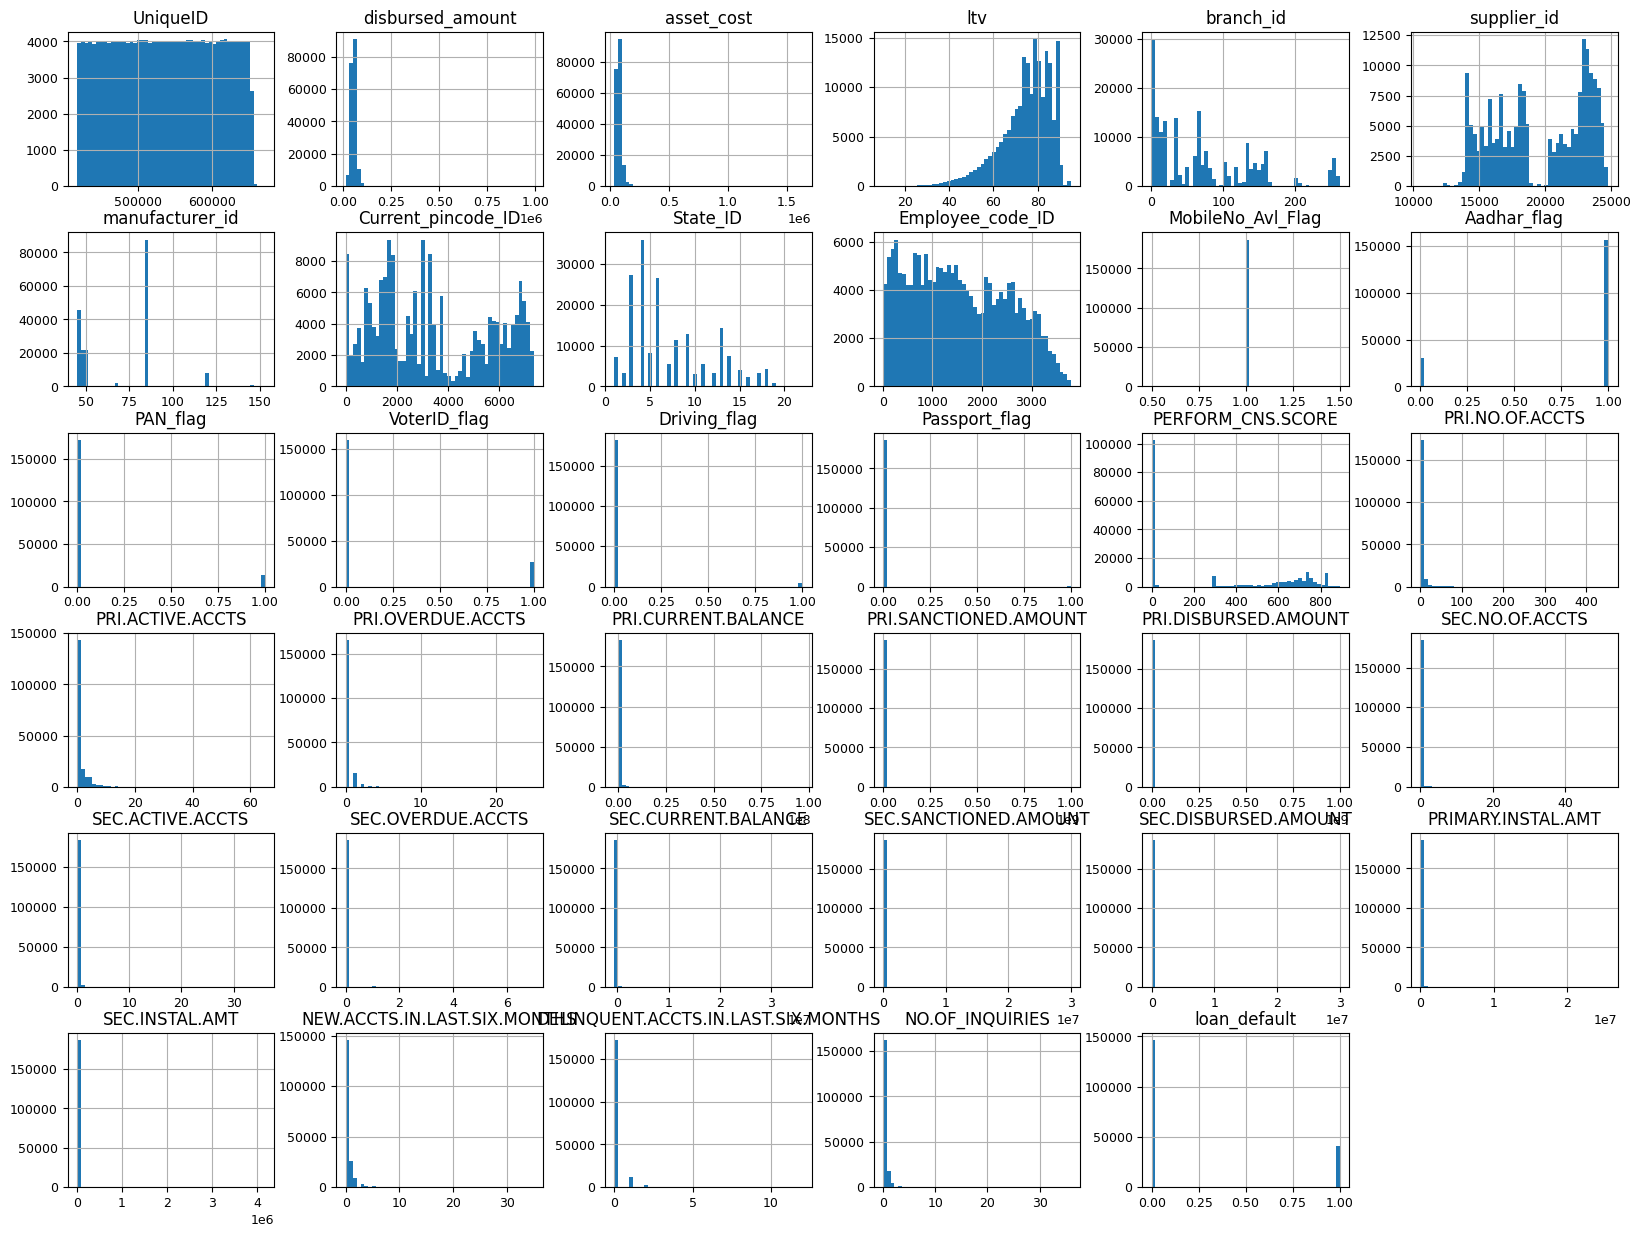

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
loans.hist(bins=50, figsize=(20,15))
plt.show()

Podemos observar algumas coisas: 
* Vários deles possuem apenas duas barras, pois são dados binários (como loan_default, Aadhar_flag, MobileNo_Avl_flag, PAN_falg etc.);
* No gráfico da variável ltv, nota-se que a maioria das pessoas que pegaram o empréstimo o fizeram no valor de pelo menos 60% do preço do veículo;
* O Unique_ID e o Employee_code_ID podem parecer interessantes de serem análisadas, porém trazen pouca informação; 
 

Além disso, podemos analisar se existe relação entre o tipo de emprego (assalariado ou autônomo) e a classificação de inadimplente ou adimplente. 

C:\Users\carol\AppData\Local\Temp\ipykernel_10356\3229015384.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Employment.Type', y='loan_default', data=loans, estimator=lambda x: sum(x)/len(x), ci=None)


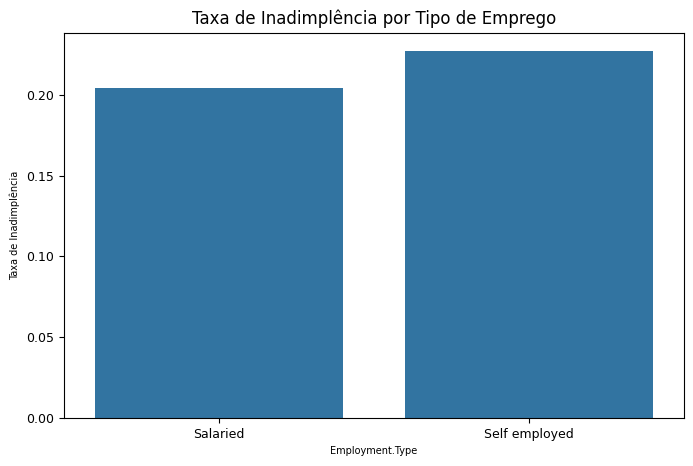

In [ ]:
sns.catplot(data=loans,kind='count',x='Employment.Type',hue='loan_default')

Acima podemos ver que existe uma taxa de inadimplencia similar entre os tipos de emprego. Porém, podemos notar que as pessoas classificadas como autonomas apresentam uma frequência maior de inadimplencia que os asalariados. 

In [23]:
loans["ltv"].describe

<bound method NDFrame.describe of 134124    82.63
23656     65.67
120852    65.61
3319      79.69
218772    85.00
          ...  
90533     76.58
87175     86.34
173418    64.04
60851     63.45
72807     79.50
Name: ltv, Length: 186523, dtype: float64>

Para estudar como nossos dados estão relacionados, veja a matriz de correlação abaixo.

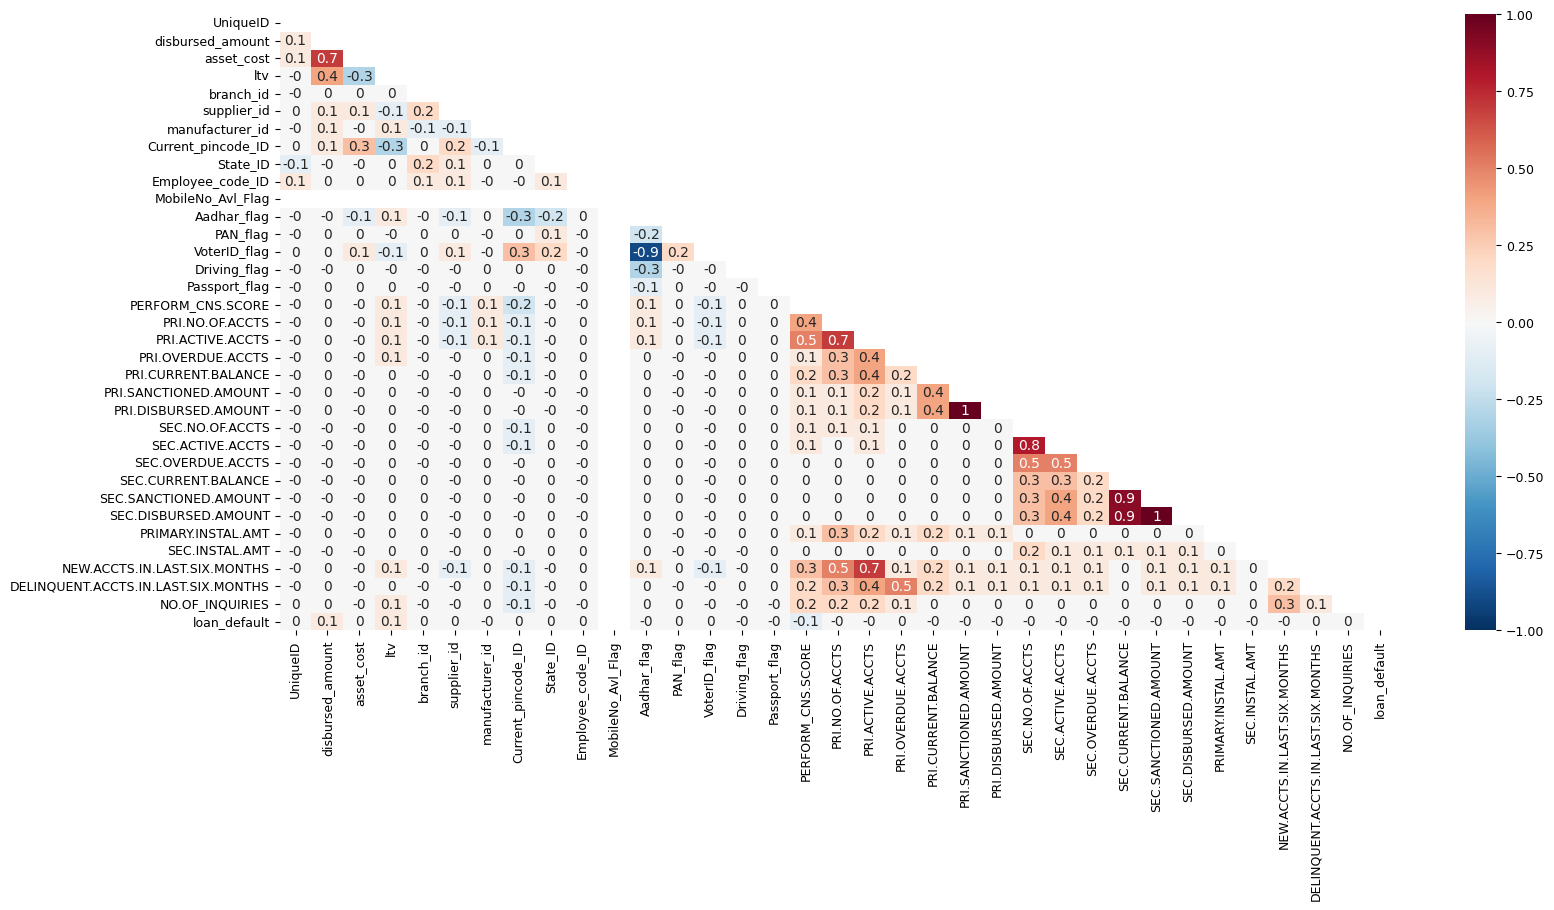

In [24]:
import seaborn as sns

corr_matrix = loans.corr(numeric_only=True)

corr_matrix = round(corr_matrix, 1)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

fig, ax = plt.subplots(1, 1, figsize=(18, 8))
sns.heatmap(corr_matrix,
            vmin=-1,
            vmax=1,
            cmap='RdBu_r',
            annot=True,
            ax=ax,
            mask=mask)
plt.show()

Note que, aparentemente nossa variável alvo não possui relação signficativa com nenhuma outra caracterítica do nosso dataset. Isso acontece, pois é um problema de classificação binária. Assim, é difícil encontrar relação linear entre os dados e o alvo.

In [25]:
corr_matrix["loan_default"].sort_values(ascending=False)

loan_default                           1.0
disbursed_amount                       0.1
ltv                                    0.1
UniqueID                               0.0
branch_id                              0.0
asset_cost                             0.0
manufacturer_id                       -0.0
Current_pincode_ID                     0.0
State_ID                               0.0
supplier_id                            0.0
Aadhar_flag                           -0.0
PAN_flag                               0.0
VoterID_flag                           0.0
Driving_flag                          -0.0
Passport_flag                         -0.0
PRI.NO.OF.ACCTS                       -0.0
PRI.ACTIVE.ACCTS                      -0.0
Employee_code_ID                       0.0
SEC.CURRENT.BALANCE                   -0.0
PRI.OVERDUE.ACCTS                      0.0
PRI.SANCTIONED.AMOUNT                 -0.0
PRI.CURRENT.BALANCE                   -0.0
SEC.NO.OF.ACCTS                       -0.0
SEC.ACTIVE.

Para ver isso graficamente, podemos usar a matriz de dispersão entre o loan_default e as três variáveis que apresentação maior correlação com a feature alvo (mesmo que pequena).

array([[<Axes: xlabel='loan_default', ylabel='loan_default'>,
        <Axes: xlabel='PERFORM_CNS.SCORE', ylabel='loan_default'>,
        <Axes: xlabel='disbursed_amount', ylabel='loan_default'>,
        <Axes: xlabel='ltv', ylabel='loan_default'>],
       [<Axes: xlabel='loan_default', ylabel='PERFORM_CNS.SCORE'>,
        <Axes: xlabel='PERFORM_CNS.SCORE', ylabel='PERFORM_CNS.SCORE'>,
        <Axes: xlabel='disbursed_amount', ylabel='PERFORM_CNS.SCORE'>,
        <Axes: xlabel='ltv', ylabel='PERFORM_CNS.SCORE'>],
       [<Axes: xlabel='loan_default', ylabel='disbursed_amount'>,
        <Axes: xlabel='PERFORM_CNS.SCORE', ylabel='disbursed_amount'>,
        <Axes: xlabel='disbursed_amount', ylabel='disbursed_amount'>,
        <Axes: xlabel='ltv', ylabel='disbursed_amount'>],
       [<Axes: xlabel='loan_default', ylabel='ltv'>,
        <Axes: xlabel='PERFORM_CNS.SCORE', ylabel='ltv'>,
        <Axes: xlabel='disbursed_amount', ylabel='ltv'>,
        <Axes: xlabel='ltv', ylabel='ltv'>]], dty

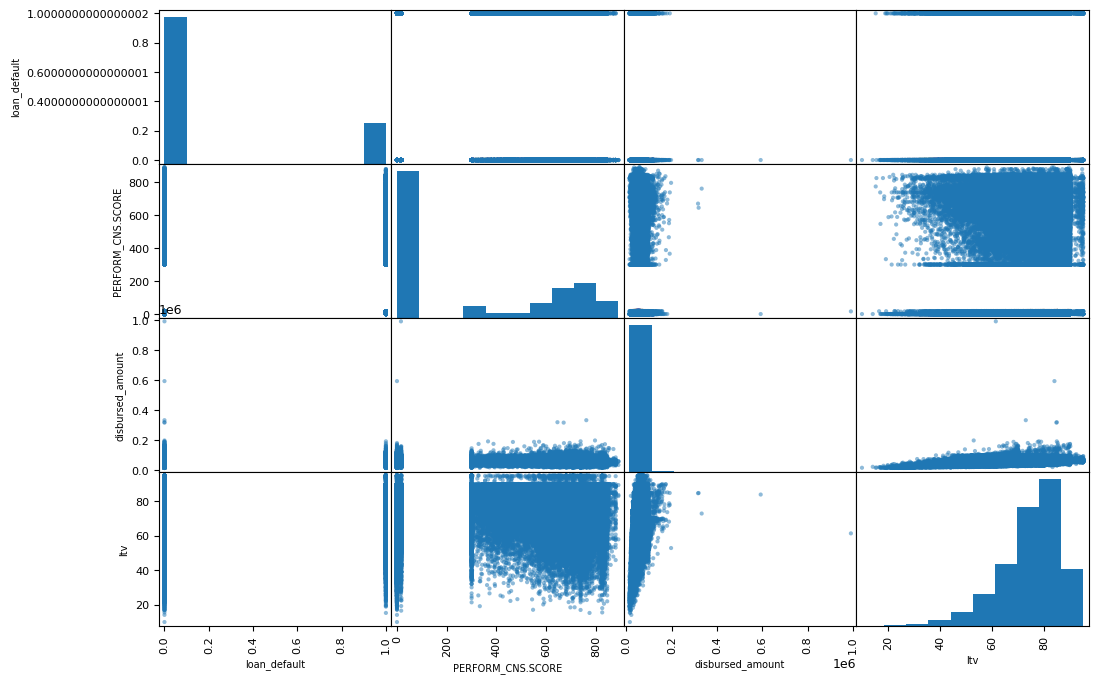

In [26]:
from pandas.plotting import scatter_matrix

attributes = ["loan_default", "PERFORM_CNS.SCORE", "disbursed_amount",
              "ltv"]
scatter_matrix(loans[attributes], figsize=(12, 8))

Perceba que a baixa correlação linear com a variável alvo se mostra também evidente nos gráficos acima, uma vez que nenhum deles se assemelha a uma reta com inclinação positiva (ou negativa).

# Feature Engineering

In [27]:
from IPython.display import HTML, Math
display(HTML("<script src='https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.3/"
             "latest.js?config=default'></script>"))

Afim de capturar relações mais complexas entre as variáveis, pensamos nas três seguintes novas features:

*   DOC_NUM: número de documentos enviados pelo cliente.

In [28]:
Math(r"\text{DOC\_ NUM} = \text{Aadhar\_ flag}+\text{PAN\_ flag}+\text{VoterID\_ flag}+\text{Driving\_ flag}+\text{Passport\_ flag}.")

<IPython.core.display.Math object>

Note que as variáveis que estamos somando são 0 ou 1, logo ao somarmos elas, obtemos exatamente quantos decumentos foram entregados

*   REL_DEBT: proporção entre o valor do empréstimo e o saldo total aberto em ativo.

In [29]:
Math(r"\text{REL\_ DEBT} = \frac{\text{PRI.DISBURSED.AMOUNT}}{\text{PRI.CURRENT.BALANCE}}.")

<IPython.core.display.Math object>

* DISBURSED_ASSET: proporção entre o valor do empréstimo e o custo do ativo financiado.

In [30]:
Math(r"\text{DISBURSED\_ASSET} = \frac{\text{PRI.DISBURSED.AMOUNT}}{\text{asset\_ cost}}.")

<IPython.core.display.Math object>

Obs para o professor: Como a correlação linear não é uma boa métrica para avaliarmos se a nossa escolha de novas features foi feliz, podemos treinar nossos modelos com e sem essas novas featrues e avaliar qual performou melhor. Porém, por questões de tempo, treinaremos apenas no conjunto com as novas variáveis.

# Preparando os dados

Prieiramente vamos retirar a feature "loans_default" do nosso conjunto de treino, uma vez que essa variável será o nosso rótulo.

In [32]:
loans = strat_train_set.drop("loan_default", axis=1)
loans_labels = strat_train_set["loan_default"].copy()

Mudamos a ordem de forma que tenhamos:

1º- Colunas numéricas 

2º- Colunas categóricas, menos a  PERFORM_CNS.SCORE.DESCRIPTION

3º- Colunas a serem removidas

4º- PERFORM_CNS.SCORE.DESCRIPTION

Dessa forma, os índices fixados das colunas não serão alterados ao adicionarmos ou removermos features.

In [33]:
from sklearn.preprocessing import FunctionTransformer

num_cols = loans.select_dtypes(include=['number']).columns.tolist()
remove = ["UniqueID","Employee_code_ID"]
num_cols = [col for col in num_cols if col not in remove]
except_cols = ["DisbursalDate","Date.of.Birth","AVERAGE.ACCT.AGE","CREDIT.HISTORY.LENGTH","Employment.Type"]
cat_cols = loans.select_dtypes(exclude=['number']).columns.tolist()
cat_cols = [col for col in cat_cols if col not in except_cols]
new_order = num_cols + except_cols + remove + cat_cols
loans = loans[new_order]

def change_columns(X):
  X = X.copy()
  X = pd.DataFrame(X, columns=columns)
  X = X[new_order]
  return X.to_numpy()

permutate_columns = FunctionTransformer(change_columns, validate=False)

In [34]:
columns_rearranged = loans.columns.tolist()

### Adicionando e removendo colunas

A partir de agora vamos iniciar a etapa de limpeza de dados!

Vamos criar uma função que adciona nossas novas features.

In [35]:
aadhar_ix, pan_ix, voterid_ix, driving_ix, passaport_ix, pri_current_balance_ix, pri_disbursed_amount_ix, asset_ix = [
    list(loans.columns).index(col)
    for col in ("Aadhar_flag","PAN_flag","VoterID_flag","Driving_flag", "Passport_flag","PRI.CURRENT.BALANCE","PRI.DISBURSED.AMOUNT","asset_cost")]

def add_extra_features(X,add_doc_num=True,add_rel_debt=True,add_disbursed_asset=True):

    if add_doc_num:
        doc_num=X[:,aadhar_ix]+X[:,pan_ix]+X[:,voterid_ix]+X[:,driving_ix]+X[:,passaport_ix]
        X = np.c_[X, doc_num]
    if add_rel_debt:
        rel_debt = np.divide(X[:, pri_disbursed_amount_ix], X[:, pri_current_balance_ix], where= X[:, pri_current_balance_ix] != 0)
        rel_debt[ X[:, pri_current_balance_ix]==0]=np.nan
        X = np.c_[X,rel_debt]
    if add_disbursed_asset:
        disbursed_asset= np.divide(X[:, pri_disbursed_amount_ix],X[:,asset_ix], where=X[:,asset_ix] != 0)
        disbursed_asset[X[:,asset_ix]==0]=np.nan
        X = np.c_[X,disbursed_asset]
    return X

attr_adder = FunctionTransformer(add_extra_features,
                                 validate=False,
                                 kw_args={"add_doc_num": False,
                                          "add_rel_debt": False,
                                          "add_disbursed_asset": False
                                          })

Agora, uma função para tirar as colunas UniqueID, Employee_code_ID. Vamos fazer isso, uma vez que esses dados são completamente arbitrários e apenas identificam clientes e funcionários para a empresa. Além disso, iremos tirar a coluna PERFORM_CNS.SCORE.DESCRIPTION, pelos motivos mencionados anteriormente e, mais ainda, pois essa será a única variável categórica que não iremos treansformar em numérico. Portanto, retirar a mesma, poupará-nos de usar outros métodos de tratamento de variável categórica como o OneHotEncoded, reduzindo o custo computacional (note que PERFORM_CNS.SCORE.DESCRIPTION tem várias classificações diferentes).

In [36]:
uniqueid_ix, employee_ix, perform_description_ix = [
    list(loans.columns).index(col)
    for col in ("UniqueID", "Employee_code_ID","PERFORM_CNS.SCORE.DESCRIPTION")]
def drop_columns(X):
    X = np.delete(X, [uniqueid_ix,employee_ix,perform_description_ix], 1)
    return X

attr_drop = FunctionTransformer(drop_columns, validate=False)

### Transformando dados para variáveis numéricas

Note que as colunas DisbursalDate e Date.of.Birth são datas. Assim, para transforma-las em dados numéricos utilizaremos o Unix timestamp. Primeiramente, vamos arrumar as datas, para deixar os anos em sua grafia completa (e em uma ordem específica para usar a função np.datetime64) e depois criaremos uma função que modifica as datas para Unix.

In [37]:
def convert_date(date_str):
    day, month, year = date_str.split('-')
    if int(year) >= 25:
        year = '19' + year
    else:
        year = '20'+year
    return f"{year}-{month}-{day}"

In [38]:
from sklearn.preprocessing import FunctionTransformer
disbursal_date_ix, birthday_ix = [
    list(loans.columns).index(col)
    for col in ("DisbursalDate", "Date.of.Birth")]
def timestamp_optimized(X):
  dates1 = np.array([convert_date(date) for date in X[:, disbursal_date_ix]])
  dates1 = np.array([np.datetime64(date) for date in dates1])
  X[:,disbursal_date_ix] = (dates1-np.datetime64('1970-01-01T00:00:00')) / np.timedelta64(1, 's')
  dates2 = np.array([convert_date(date) for date in X[:, birthday_ix]])
  dates2 = np.array([np.datetime64(date) for date in dates2])
  X[:,birthday_ix]=(dates2-np.datetime64('1970-01-01T00:00:00')) / np.timedelta64(1, 's')
  return X
date_opt = FunctionTransformer(timestamp_optimized,
                                 validate=False)

As colunas AVERAGE.ACCT.AGE e CREDIT.HISTORY.LENGTH indicam período de tempo. Porém, elas não são uma data específica, logo não podemos usar o Unix timestemp. Assim, para transforma-las em varáveis númericas, iremos calcular o total de meses informados.

In [39]:
import re
def convert_to_months(time):
        num = re.findall(r'(\d+)\s*yrs\s*(\d+)\s*mon', time)
        if num:
            anos, meses = map(int, num[0])
            meses_totais = anos*12+meses
            return meses_totais

In [40]:
average_idx, credit_history_idx = [
    list(loans.columns).index(col)
    for col in ("AVERAGE.ACCT.AGE", "CREDIT.HISTORY.LENGTH")]
def month_count(X):
    for i in [average_idx, credit_history_idx]:
        X[:,i]=np.array([convert_to_months(date) for date in X[:, i]])
    return X
month_cnt = FunctionTransformer(month_count,
                                 validate=False)

### Imputação

Vamos verificar, primeiramente, se temos dados faltantes.

In [43]:
sample_incomplete_rows = loans[loans.isnull().any(axis=1)].copy()
sample_incomplete_rows

,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,State_ID,MobileNo_Avl_Flag,Aadhar_flag,...,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,NO.OF_INQUIRIES,DisbursalDate,Date.of.Birth,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,Employment.Type,UniqueID,Employee_code_ID,PERFORM_CNS.SCORE.DESCRIPTION
3319,66169,84080,79.69,146,14142,45,2955,14,1,1,...,0,0,31-10-18,27-08-93,0yrs 11mon,3yrs 8mon,NaN,652769,661,M-Very High Risk
12242,43369,73664,65.16,7,18714,86,5759,3,1,1,...,0,0,21-08-18,15-08-66,2yrs 2mon,2yrs 2mon,NaN,452936,698,A-Very Low Risk
52266,46649,65100,74.50,16,22004,45,3017,14,1,1,...,0,0,28-08-18,01-01-75,0yrs 0mon,0yrs 0mon,NaN,470174,1915,No Bureau History Available
33925,57413,69318,85.11,67,22045,86,1411,6,1,1,...,0,0,27-10-18,21-10-97,1yrs 9mon,2yrs 1mon,NaN,630171,1800,F-Low Risk
149663,23100,43983,55.70,146,16920,48,3036,14,1,1,...,0,0,12-10-18,01-01-90,0yrs 6mon,3yrs 0mon,NaN,570949,1928,B-Very Low Risk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9882,57513,74157,78.89,17,20335,86,3252,17,1,1,...,0,0,27-10-18,08-10-85,0yrs 0mon,0yrs 0mon,NaN,631477,1249,No Bureau History Available
119311,47349,64000,75.00,5,23505,51,3332,9,1,1,...,0,0,24-09-18,17-07-82,0yrs 10mon,3yrs 6mon,NaN,532136,259,G-Low Risk
198521,79079,100533,79.58,16,14305,86,2943,17,1,1,...,0,0,22-10-18,18-07-97,1yrs 0mon,2yrs 11mon,NaN,598284,2768,K-High Risk
219620,40054,52800,79.55,103,23750,51,7246,7,1,1,...,0,0,17-10-18,15-12-98,0yrs 0mon,0yrs 0mon,NaN,585769,3074,No Bureau History Available


Para encontrar o melhor método de imputação vamos fazer um Random search. Buscaremos hiperparâmetros para imputação aqui, porém poderiamos fazer essa procura junto com a busca de híperparâmetros dos modelos. Essa separação é feita para diminuirmos o custo computacional que teríamos se fizéssemos o random search junto com os modelos. Para o treinamento da imputação, usaremos o random forest com parâmetros padrões.

Para isso, vamos transformar a coluna Employment.Type em numérica. Note que nessa coluna temos apenas em duas classificações, Self Employed e Salaried. Assim, vamos classificar Salaried como sendo 1 e Self employed como sendo 0. 

In [43]:
loans["Employment.Type"].value_counts()

Employment.Type
Self employed    102101
Salaried          78295
Name: count, dtype: int64

In [44]:
employment_idx = [list(loans.columns).index('Employment.Type')]

def mapping(i):
    if isinstance(i, float) and np.isnan(i):
        return np.nan
    elif i == 'Salaried':
        return 1
    elif i == 'Self employed':
        return 0

cat_to_num = np.vectorize(mapping, otypes=[float])

def employment_to_num(X):
    X = X.copy()
    X[:, employment_idx] = cat_to_num(X[:, employment_idx])
    return X

employment_num = FunctionTransformer(employment_to_num, validate=False)



Perceba que obtemos o resultado desejado.

In [45]:
loans_np = loans.to_numpy()
loans_np_employ = employment_to_num(loans_np)
loans_np_employ_pd = pd.DataFrame(loans_np_employ, columns=columns_rearranged, index=loans.index)
loans_np_employ_pd['Employment.Type']

134124    1.0
23656     0.0
120852    0.0
3319      NaN
218772    1.0
         ... 
90533     0.0
87175     0.0
173418    0.0
60851     1.0
72807     0.0
Name: Employment.Type, Length: 186523, dtype: object

 Como nosso conjunto de dados é muito grande, vamos selecionar uma amostra represetativa para encontrar o melhor modelo de imputação.

In [46]:
valores_nulo = loans['Employment.Type'].isnull()
stratify_var = valores_nulo.astype(int)
loans_employment = employment_to_num(loans.to_numpy())
loans_employment = np.delete(loans_employment[:,:-1],[disbursal_date_ix, birthday_ix,average_idx,credit_history_idx],1)

X_train, X_sample, y_train, y_sample = train_test_split(
    loans_employment,
    loans_labels,
    test_size=0.2,
    stratify=stratify_var,
    random_state= seed
)

Testaremos dois modelos de imputação, o SimpleImputer e o IterativeImputer. Para o SimpleImputer iremos fazer um Grid Search, já que temos poucas combinações a serem feitas. 

In [109]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler

model = RandomForestClassifier(random_state=seed)

pipeline_simple = Pipeline([
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer()),
    ('classifier', model)
])

simple_imputer_params = {
    "imputer__strategy": ['mean', 'median'],
}

grid_search_simple = GridSearchCV(
    pipeline_simple,
    param_grid=simple_imputer_params,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
)
grid_search_simple.fit(X_sample, y_sample)

print("Melhores parâmetros:", grid_search_simple.best_params_)
print("Melhor score (recall):", grid_search_simple.best_score_)

Melhores parâmetros: {'imputer__add_indicator': False, 'imputer__copy': True, 'imputer__strategy': 'median'}
Melhor score (recall): 0.7808604744672296


Para selecionar os  melhores hiperparâmetros do IterativeImputer, faremos um Random Search utilizando o Random Forest, pois de acordo com o artigo "Missing Data Imputation Through the Use of the Random Forest Algorithm" de Pantanowitz, ele é superior a outros modelos testados em termos de acuracia e tempo computacional.

Referência: Pantanowitz, A., Marwala, T. (2009). Missing Data Imputation Through the Use of the Random Forest Algorithm. In: Yu, W., Sanchez, E.N. (eds) Advances in Computational Intelligence. Advances in Intelligent and Soft Computing, vol 116. Springer, Berlin, Heidelberg. https://doi.org/10.1007/978-3-642-03156-4_6.

In [49]:
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from scipy.stats import randint, uniform

model = RandomForestClassifier(random_state=seed)

pipeline_iterative = Pipeline([
    ('imputer', IterativeImputer()),
    ('classifier', model)
])


iterative_imputer_params = {
    'imputer__estimator': [BayesianRidge(), RandomForestRegressor(), DecisionTreeRegressor()],
    'imputer__max_iter': randint(10,50),
    'imputer__tol': uniform(1e-3,1e-5), 
    'imputer__initial_strategy': ['mean', 'median', 'most_frequent'],
    'imputer__imputation_order': ['ascending', 'descending', 'random']
}


random_search_iterative = RandomizedSearchCV(
    pipeline_iterative,
    param_distributions=iterative_imputer_params,
    scoring='accuracy',
    cv=4,
    n_iter=15,
    random_state=seed,
    n_jobs=-1,
)

random_search_iterative.fit(X_sample, y_sample)

c:\Users\carol\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


RandomizedSearchCV(cv=4,
                   estimator=Pipeline(steps=[('imputer', IterativeImputer()),
                                             ('classifier',
                                              RandomForestClassifier(random_state=4))]),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'imputer__estimator': [BayesianRidge(),
                                                               RandomForestRegressor(),
                                                               DecisionTreeRegressor()],
                                        'imputer__imputation_order': ['ascending',
                                                                      'descending',
                                                                      'random'],
                                        'imputer__initial_strategy': ['mean',
                                                                      'median',
                                                                      'most_frequent'],
                                        'imputer__max_iter': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001B396C356A0>,
                                        'imputer__tol': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001B389837B90>},
                   random_state=4, scoring='accuracy')

Segue abaixo os resultados compilados:

In [50]:
results_simple = grid_search_simple.cv_results_
new_col_simple = pd.DataFrame(['SimpleImputer'] * 8,columns=["Imputer"])
df_results_simple = pd.concat([new_col_simple,pd.DataFrame(results_simple)],axis=1)

results_iterative=random_search_iterative.cv_results_
new_col_iterative = pd.DataFrame(['IterativeImputer'] * 15,columns=["Imputer"])
df_results_iterative=pd.concat([new_col_iterative,pd.DataFrame(results_iterative)],axis=1)

df_results_total = pd.concat([df_results_simple,df_results_iterative],axis=0,ignore_index=True)
df_results_total = df_results_total[
    ['Imputer','mean_test_score', 'std_test_score', 'params']
]

df_results_total = df_results_total.sort_values(by='mean_test_score', ascending=False)

df_results_total

,Imputer,mean_test_score,std_test_score,params
15,IterativeImputer,0.781450,0.001169,{'imputer__estimator': RandomForestRegressor()...
10,IterativeImputer,0.781129,0.001433,{'imputer__estimator': RandomForestRegressor()...
16,IterativeImputer,0.781129,0.001162,{'imputer__estimator': RandomForestRegressor()...
18,IterativeImputer,0.780914,0.002513,{'imputer__estimator': DecisionTreeRegressor()...
5,SimpleImputer,0.780860,0.001425,"{'imputer__add_indicator': False, 'imputer__co..."
7,SimpleImputer,0.780860,0.001425,"{'imputer__add_indicator': False, 'imputer__co..."
13,IterativeImputer,0.780592,0.002064,{'imputer__estimator': DecisionTreeRegressor()...
1,SimpleImputer,0.780592,0.001557,"{'imputer__add_indicator': True, 'imputer__cop..."
3,SimpleImputer,0.780592,0.001557,"{'imputer__add_indicator': True, 'imputer__cop..."
12,IterativeImputer,0.780405,0.001648,{'imputer__estimator': RandomForestRegressor()...


Observamos que o InteractiveImputer obteve os melhores scores, mas o modelo SimpleImputer apresentou scores muito próximos. Considerando o custo computacional, decidimos optar pelo SimpleImputer.

In [47]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(add_indicator=False, copy=True, strategy='median')

# Selecionar e treinar um modelo

Vamos compilar todas as funções anteriormente criadas em um só pipeline que, quando aplicada em um conjunto de dados, irá prepara-lo para o uso em modelos. 

In [48]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

full_pipeline = Pipeline([
        ('permute_col', permutate_columns),
        ('attribs_adder', attr_adder),
        ('attribs_drop', attr_drop),
        ('date_opt', date_opt),
        ('month_count', month_cnt),
        ('employment_num', employment_num),
        ('std_scaler', StandardScaler()),
        ('imputer', imputer),
    ])

Note que organizamos o pipeline da seguinte forma: 
* Primeiro permutamos as colunas, para que as operações seguintes que precisam de índices fixados não tenhas tais índices alterados ao retirarmos ou acrescentarmos colunas; 
* Acrescentamos as novas colunas feitas no Feature Engineering;
* Removemos as variáveis UniqueID, Employee_code_ID
* Agora, transformaremos variáveis categóricas em numéricas, com as funções date_opt, month_count e employment_num;
* Como o melhor modelo para imputação foi o KNNImputer, precisamos escalonar os dados;
* Por fim, agora que todas as variáveis são numéricas e estão escalonadas, podemos imputar dados faltantes. 

In [53]:
stratify_var = loans["PERFORM_CNS.SCORE.DESCRIPTION"]

X_train_model, X_sample_model, y_train_model, y_sample_model = train_test_split(
    loans,
    loans_labels,
    test_size=0.05,
    stratify=stratify_var,
    random_state= seed
)

Agora, vamos de fato selecionar e treinar o nosso modelo. Para isso, aplicaremos a validação cruzada através do Random Search, com o objetivo de identificar as abordagens que apresentam um bom recall e uma boa acurácia, ou seja, aquelas que minimizam a taxa de falsos negativos e tem alta taxa de acertos. Assim, foi considerado SGD (Stochastic Gradient Descent). A escolha desse modelo foi baseada nas recomendações do sklearn (https://scikit-learn.org/1.5/machine_learning_map.html).

Note que minimizar falsos negativos é de maior interesse da Carrara Emprestimos, uma vez que um falso negativo pode resultar na empresa oferecer crédito para uma mal pagante e acabar perdendo dinheiro.

### SGD

Realizaremos dois Random Search para encontrar os melhores parâmetros para o SGD. No primeiro, utilizaremos learning_rate: ['constant', 'invscaling', 'adaptive'] e eta0: uniform(1e-5, 1e-1). No segundo, configuraremos learning_rate como 'optimal'. Dividimos em dois casos porque, ao usar 'optimal', não é possível configurar o parâmetro eta0."

In [68]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import recall_score
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV

sgd1 = SGDClassifier(random_state=seed)

pipeline_sgd1 = Pipeline([
    ('full_pipe',full_pipeline),
    ('classifier', sgd1)
])

param_distribs_sgd1 = {
    'classifier__loss': [ 'hinge','squared_hinge','squared_error', 'squared_epsilon_insensitive','log_loss','perceptron'],
    'classifier__learning_rate':['constant', 'invscaling', 'adaptive'],
    'classifier__eta0': uniform(1e-5, 1e-1),
    'classifier__penalty': ['l2', 'l1'],
    'classifier__alpha': uniform(1e-7, 1e-1),
    'classifier__tol': uniform(1e-3, 1e-1),
    'classifier__max_iter': randint(5000,45000),
}

scoring = {
    'recall': 'recall',
    'accuracy': 'accuracy'
}

rnd_search_sgd1 = RandomizedSearchCV(pipeline_sgd1,
                                param_distributions=param_distribs_sgd1,
                                n_iter=10,
                                cv=3,
                                scoring='recall',
                                random_state=seed,
                                error_score='raise')

rnd_search_sgd1.fit(loans, loans_labels)

print("Melhores parâmetros:", rnd_search_sgd1.best_params_)
print("Melhor score:", rnd_search_sgd1.best_score_)

c:\Users\carol\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\carol\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\carol\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Melhores parâmetros: {'classifier__alpha': np.float64(0.04463501974261807), 'classifier__eta0': np.float64(0.044144853091052615), 'classifier__learning_rate': 'constant', 'classifier__loss': 'perceptron', 'classifier__max_iter': 19748, 'classifier__penalty': 'l1', 'classifier__tol': np.float64(0.07433801675105699)}
Melhor score: 1.0


Obtivemos um score de 1.0, o que indica que o modelo provavelmente está sofrendo de overfitting!

In [ ]:
sgd = SGDClassifier(random_state=seed, learning_rate='optimal')

pipeline_sgd = Pipeline([
    ('full_pipe',full_pipeline),
    ('classifier', sgd)
])

param_distribs_sgd = {
    'classifier__loss': [ 'hinge','squared_hinge','squared_error', 'squared_epsilon_insensitive',
                         'log_loss','perceptron'],
    'classifier__penalty': ['l2', 'l1'],
    'classifier__alpha': uniform(1e-7, 1e-1),
    'classifier__tol': uniform(1e-3, 1e-1),
    'classifier__max_iter': randint(5000,45000),
}



rnd_search_sgd = RandomizedSearchCV(pipeline_sgd,
                                param_distributions=param_distribs_sgd,
                                n_iter=10,
                                cv=3,
                                scoring=scoring,
                                refit='recall',
                                random_state=seed,
                                error_score='raise')

rnd_search_sgd.fit(loans, loans_labels)

print("Melhores parâmetros:", rnd_search_sgd.best_params_)
print("Melhor score:", rnd_search_sgd.best_score_)

c:\Users\carol\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\carol\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\carol\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\carol\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consid

Melhores parâmetros: {'classifier__alpha': np.float64(0.02160904955803764), 'classifier__loss': 'perceptron', 'classifier__max_iter': 25062, 'classifier__penalty': 'l1', 'classifier__tol': np.float64(0.0262982362383444)}
Melhor score (recall): 0.6666666666666666


### Resultados do Random Search: 

Abaixo está uma tabela com todos os modelos treinados, ordenada de forma decrescente com base na acurácia

In [78]:
cv_results_sgd1 = rnd_search_sgd1.cv_results_
cv_results_sgd = rnd_search_sgd.cv_results_


df_sgd1 = pd.DataFrame(cv_results_sgd1)
df_sgd = pd.DataFrame(cv_results_sgd)

sgd_results = pd.concat([df_sgd1, df_sgd], ignore_index=True)
sgd_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_classifier__alpha', 'param_classifier__eta0',
       'param_classifier__learning_rate', 'param_classifier__loss',
       'param_classifier__max_iter', 'param_classifier__penalty',
       'param_classifier__tol', 'params', 'split0_test_recall',
       'split1_test_recall', 'split2_test_recall', 'mean_test_recall',
       'std_test_recall', 'rank_test_recall', 'split0_test_accuracy',
       'split1_test_accuracy', 'split2_test_accuracy', 'mean_test_accuracy',
       'std_test_accuracy', 'rank_test_accuracy'],
      dtype='object')

In [76]:
cv_results_sgd1 = rnd_search_sgd1.cv_results_
cv_results_sgd = rnd_search_sgd.cv_results_


df_sgd1 = pd.DataFrame(cv_results_sgd1)
df_sgd = pd.DataFrame(cv_results_sgd)

sgd_results = pd.concat([df_sgd1, df_sgd], ignore_index=True)
sgd_results_summary = sgd_results[['mean_test_accuracy',
                                   'mean_test_recall',
                                   'param_classifier__alpha',
                                   'param_classifier__eta0',
                                   'param_classifier__learning_rate',
                                   'param_classifier__loss',
                                   'param_classifier__max_iter',
                                   'param_classifier__tol',
                                  ]].rename(columns={
    'mean_test_accuracy': 'Acurácia',
    'mean_test_recall': 'Recall'
})

df_sorted = sgd_results_summary.sort_values(by='Acurácia', ascending=False)

df_sorted


,Acurácia,Recall,param_classifier__alpha,param_classifier__eta0,param_classifier__learning_rate,param_classifier__loss,param_classifier__max_iter,param_classifier__tol
0,0.782853,0.000000,0.096703,0.054733,invscaling,hinge,16863,0.070773
3,0.782853,0.000000,0.064392,0.081116,invscaling,squared_error,8002,0.095500
13,0.782853,0.000000,0.036150,NaN,NaN,hinge,42047,0.060733
7,0.782836,0.000025,0.022303,0.013885,invscaling,squared_error,5439,0.069667
1,0.782552,0.002321,0.021609,0.097637,adaptive,squared_hinge,37616,0.078938
14,0.782231,0.000988,0.000899,NaN,NaN,hinge,9802,0.096665
16,0.705950,0.154877,0.044635,NaN,NaN,perceptron,27304,0.018586
10,0.705591,0.144508,0.096703,NaN,NaN,perceptron,16863,0.070773
18,0.688269,0.311508,0.052170,NaN,NaN,squared_hinge,34401,0.023876
2,0.682023,0.193689,0.019769,0.086309,constant,perceptron,35205,0.027647


In [79]:
best_model= SGDClassifier(random_state=seed, learning_rate='optimal',
                          alpha= 0.052170, loss='squared_hinge',max_iter=34401,tol=0.023876)

# Modelo e Teste Final

Vamos agora testar nosso método escolhido e treinado (no conjunto treino) no conjunto de teste. Lembre-se que nosso conjunto de teste final ainda não foi utilizado, pois ainda estamos na primeira versão do nosso projeto e só após as considerações do professor iremos utlizar nosso conjunto de teste definitivo.

In [83]:
X_train = full_pipeline.fit_transform(loans)

In [84]:
best_model.fit(X_train, loans_labels)

c:\Users\carol\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


SGDClassifier(alpha=0.05217, loss='squared_hinge', max_iter=34401,
              random_state=4, tol=0.023876)

In [85]:
X_test = strat_test_set.drop("loan_default", axis=1)
y_test = strat_test_set["loan_default"].copy()

X_test_prepared = full_pipeline.fit_transform(X_test)
final_predictions = best_model.predict(X_test_prepared)

final_recall = recall_score(y_test, final_predictions)

In [86]:
from sklearn.metrics import f1_score, recall_score, accuracy_score
print("Accuracy of model ",accuracy_score(y_test, final_predictions ))
print("Recall Score ",recall_score(y_test, final_predictions ))

Accuracy of model  0.698119276875898
Recall Score  0.13632766125840917


Note que infelizmente o recall genearalizado não foi muito bom, porém a acurácia teve um resultado relativamente satisfatório. Devido a baixa performance do recall, esse modelo pode não ser o ideal para a empresa.

A escolha correta agora, seria fazer novas buscas por métodos melhores (que performam melhor no recall). Porém, por falta de tempo, nos contentamos com o método escolhido.

Agora basta aplicarmos o mesmo no conjunto de teste real.

### Teste final

O conjunto de teste real não apresenta a coluna de predição, então não conseguimos associar um score ao nosso modelo aqui. Podemos apenas predizer os rótulos.

In [89]:
teste_final = pd.read_csv('test.csv')

In [90]:
columns_test = test_final.columns.tolist()
test_final = pd.DataFrame(test_final, columns=columns_test)

In [ ]:
X_test_final_prepared = full_pipeline.fit_transform(test_final)
test_final_predictions = best_model.predict(X_test_final_prepared)


In [93]:
test_final_predictions 

array([0, 1, 0, ..., 0, 1, 0])